In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
np.random.seed(10)
import re
import ast
import string
from bs4 import BeautifulSoup

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('/content/drive/MyDrive/Skripsi Collab/HASIL PREPROCESSING10.csv')
datasenti = data[['Tweet', 'Sentimen']]

MAX_NB_WORDS = 9799
MAX_SEQUENCE_LENGHT = 50

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, split=" ")
tokenizer.fit_on_texts(data['Tweet'].values)
word_index = tokenizer.word_index
print('index %s' % len(word_index))
print(word_index)
X = tokenizer.texts_to_sequences(data['Tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGHT)

Y = pd.get_dummies(data['Sentimen']).values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,  test_size=0.30, random_state=42 )


FileNotFoundError: ignored

In [ ]:
X_train.shape

(3084, 70)

In [ ]:

from keras.layers import Embedding, LSTM, Dropout, Dense, Flatten
from keras.regularizers import l2
from keras.models import Sequential
import keras

MAX_NB_WORDS = 10130
MAX_SEQUENCE_LENGHT = 50
EMBEDDING_DIM = 50

model = Sequential()
embedding_layer = Embedding(MAX_NB_WORDS+1, EMBEDDING_DIM, input_length=X_train.shape[1])
model.add(embedding_layer)
model.add(LSTM(400, dropout=0.9))
model.add(Dense(3, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 50)            506550    
_________________________________________________________________
lstm_10 (LSTM)               (None, 400)               721600    
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 1203      
Total params: 1,229,353
Trainable params: 1,229,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:

epochs=45
batch_size=32
trainlstm = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=1,  validation_split=0.1)

Epoch 1/45
87/87 [==============================] - 3s 19ms/step - loss: 1.0986 - accuracy: 0.3345 - val_loss: 1.0957 - val_accuracy: 0.3528
Epoch 2/45
87/87 [==============================] - 1s 13ms/step - loss: 1.0948 - accuracy: 0.3654 - val_loss: 1.0925 - val_accuracy: 0.3592
Epoch 3/45
87/87 [==============================] - 1s 13ms/step - loss: 1.0888 - accuracy: 0.3929 - val_loss: 1.0901 - val_accuracy: 0.3463
Epoch 4/45
87/87 [==============================] - 1s 13ms/step - loss: 1.0851 - accuracy: 0.3991 - val_loss: 1.0877 - val_accuracy: 0.3883
Epoch 5/45
87/87 [==============================] - 1s 13ms/step - loss: 1.0750 - accuracy: 0.4115 - val_loss: 1.0809 - val_accuracy: 0.3722
Epoch 6/45
87/87 [==============================] - 1s 13ms/step - loss: 1.0634 - accuracy: 0.4212 - val_loss: 1.0701 - val_accuracy: 0.4078
Epoch 7/45
87/87 [==============================] - 1s 13ms/step - loss: 1.0557 - accuracy: 0.4314 - val_loss: 1.0517 - val_accuracy: 0.4272
Epoch 8/45
87

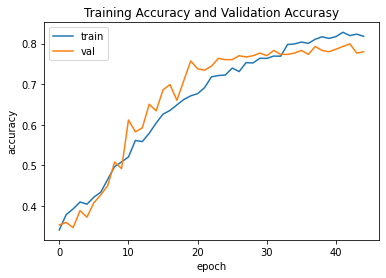

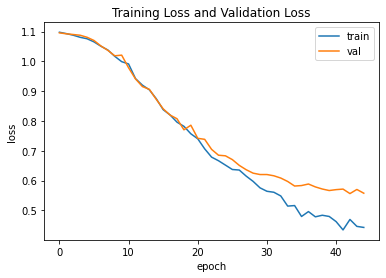

In [ ]:
import matplotlib.pyplot as plt

plt.plot(trainlstm.history['accuracy'])
plt.plot(trainlstm.history['val_accuracy'])
plt.title('Training Accuracy and Validation Accurasy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()
plt.plot(trainlstm.history['loss'])
plt.plot(trainlstm.history['val_loss'])
plt.title('Training Loss and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()


In [ ]:
#Cek akurasi data test

scores = model.evaluate(X_test,Y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))


42/42 [==============================] - 0s 6ms/step - loss: 0.5788 - accuracy: 0.7716
Accuracy: 77.16%


In [ ]:
#hitung prediksi di tiap jenis label
predictions = model.predict(X_test)
neg_count, neu_count, pos_count = 0, 0, 0
real_neg, real_neu, real_pos = 0, 0, 0
for i, prediction in enumerate(predictions):
  if np.argmax(prediction)==2:
    pos_count += 1
  elif np.argmax(prediction)==1:
    neu_count += 1
  else:
    neg_count += 1

  if np.argmax(Y_test[i])==2:
    real_pos += 1
  elif np.argmax(Y_test[i])==1:
    real_neu += 1
  else:
    real_neg += 1

print('Positive predictions: ', pos_count)
print('Neutral predictions: ', neu_count)
print('Negative predictions: ', neg_count)
print('Real positive: ', real_pos )
print('Real neutral: ', real_neu )
print('Real negative: ', real_neg )

Positive predictions:  437
Neutral predictions:  489
Negative predictions:  396
Real positive:  443
Real neutral:  467
Real negative:  412


[[313  79  20]
 [ 61 348  58]
 [ 22  62 359]]


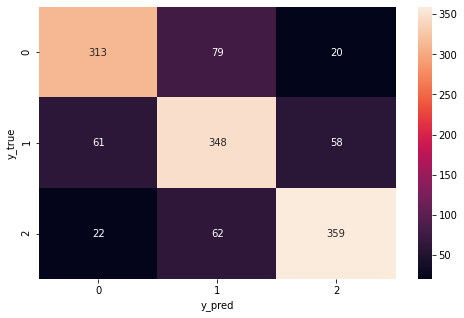

              precision    recall  f1-score   support

           0       0.79      0.76      0.77       412
           1       0.71      0.75      0.73       467
           2       0.82      0.81      0.82       443

    accuracy                           0.77      1322
   macro avg       0.77      0.77      0.77      1322
weighted avg       0.77      0.77      0.77      1322



In [ ]:
#confusian matrix
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(Y_test.argmax(axis=1), predictions.argmax(axis=1)) )

import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(Y_test.argmax(axis=1),predictions.argmax(axis=1) ), annot=True, fmt=".0f", ax=ax)
plt.ylabel("y_true")
plt.xlabel("y_pred")
plt.show()

#precision, recall, f1-score
from sklearn.metrics import classification_report
print (classification_report(Y_test.argmax(axis=1),predictions.argmax(axis=1)))

In [ ]:
#save model
model.save('/content/drive/MyDrive/model/LSTM1.h5')